# Predicting Loan Default Risk in the Banking Industry: An Exercise in Binary Classification, Feature Engineering and Neural Networks using Keras
## Designing Shallow and Deep Neural Networks for Risk Assessment in Home Loans
### Pablo X Zumba

The data set for this exercise is from the banking industry. It contains data about the home loans of 2,500 bank clients. Each row represents a single loan. The columns include the characteristics of the client who used a loan. This is a binary classification task: predict whether a loan will be bad or not (1=Yes, 0=No). This is an important task for banks to prevent bad loans from being issued.

## Description of Variables

The description of variables are provided in "Loan - Data Dictionary.docx"

## Goal

Use the **loan.csv** data set and build a model to predict **BAD**. 

Since you have a relatively small data set, I recommend using cross-validation to evaluate your accuracy.

# Read and Prepare the Data

In [2]:
# Common imports

import pandas as pd
import numpy as np

np.random.seed(42)

# Get the data

In [3]:
#We will predict the "price" value in the data set:

loan = pd.read_csv("loan.csv")
loan.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,0,25900,61064.0,94714.0,DebtCon,Office,2.0,0.0,0.0,98.809375,0.0,23.0,34.565944
1,0,26100,113266.0,182082.0,DebtCon,Sales,18.0,0.0,0.0,304.852469,1.0,31.0,33.193949
2,1,50000,220528.0,300900.0,HomeImp,Self,5.0,0.0,0.0,0.000000,0.0,2.0,NaN
3,1,22400,51470.0,68139.0,DebtCon,Mgr,9.0,0.0,0.0,31.168696,2.0,8.0,37.952180
4,0,20900,62615.0,87904.0,DebtCon,Office,5.0,NaN,NaN,177.864849,NaN,15.0,36.831076


# Split data (train/test)

In [4]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(loan, test_size=0.3)

# Data Prep

Perform your data prep here. You can use pipelines like we do in the tutorials. Otherwise, feel free to use your own data prep steps. Eventually, you should do the following at a minimum:<br>
- Separate inputs from target<br>
- Impute/remove missing values<br>
- Standardize the continuous variables<br>
- One-hot encode categorical variables<br>

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

## Separate the target variable 

In [6]:
train_target = train['BAD']
test_target = test['BAD']

train_inputs = train.drop(['BAD'], axis=1)
test_inputs = test.drop(['BAD'], axis=1)

## Feature Engineering: Derive a new column

Examples:
- Ratio of delinquent to total number of credit lines
- Ratio of loan to value of current property
- Convert yr_renovated to a binary variable (i.e., renovated or not)
- (etc.)

In [7]:
train_inputs['CLNO'].value_counts()

16.0    88
19.0    82
23.0    81
24.0    69
13.0    69
        ..
44.0     1
53.0     1
65.0     1
52.0     1
57.0     1
Name: CLNO, Length: 61, dtype: int64

<AxesSubplot: >

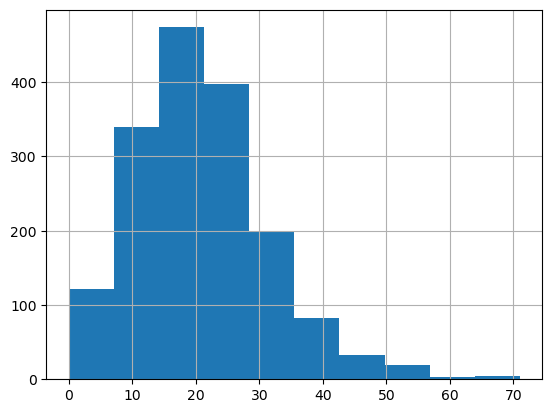

In [8]:
train_inputs['CLNO'].hist()

In [9]:
# Import power transformer from sklearn. It will help us create a "normal distribution"
from sklearn.preprocessing import PowerTransformer

PT = PowerTransformer(method = 'yeo-johnson', standardize=True)

In [13]:
transformed_CLNO = PT.fit_transform(train_inputs[['CLNO']])

array([[<AxesSubplot: title={'center': '0'}>]], dtype=object)

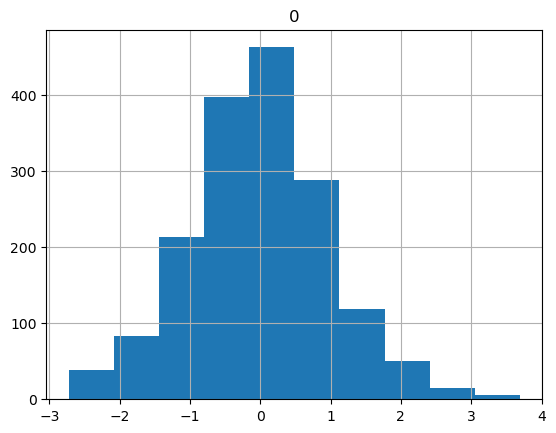

In [14]:
pd.DataFrame(transformed_CLNO).hist()

NOTE1: We didn't make the transformed variable as part of the input variables yet. To do that, we will use the pipeline.

NOTE2: We don't need to create a function (like before). This transformer already has fit() and transform(). So, we can use this in the pipeline.

##  Identify the numeric, binary, and categorical columns

In [16]:
# Identify the numerical columns
numeric_columns = train_inputs.select_dtypes(include=[np.number]).columns.to_list()

# Identify the categorical columns
categorical_columns = train_inputs.select_dtypes('object').columns.to_list()

In [19]:
# Identify the binary columns so we can pass them through without transforming
binary_columns = []

In [20]:
# Be careful: numerical columns already includes the binary columns,
# So, we need to remove the binary columns from numerical columns.

for col in binary_columns:
    numeric_columns.remove(col)

In [21]:
binary_columns

[]

In [17]:
numeric_columns

['LOAN',
 'MORTDUE',
 'VALUE',
 'YOJ',
 'DEROG',
 'DELINQ',
 'CLAGE',
 'NINQ',
 'CLNO',
 'DEBTINC']

In [22]:
categorical_columns

['REASON', 'JOB']

In [23]:
feat_eng_columns = ['CLNO']

# Pipeline

In [24]:
numeric_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())])

In [25]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [26]:
binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))])

In [27]:
# Create a pipeline for the transformed column here
my_new_column = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('powertransformer', PowerTransformer(method = 'yeo-johnson', standardize=True))])



In [28]:
preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns),
        ('binary', binary_transformer, binary_columns),
        ('trans', my_new_column, feat_eng_columns)],   
        remainder='passthrough')

#passtrough is an optional step. You don't have to use it.

# Transform: fit_transform() for TRAIN

In [29]:
#Fit and transform the train data
train_x = preprocessor.fit_transform(train_inputs)

train_x

array([[-0.31412013, -1.30301181, -0.86148829, ...,  0.        ,
         0.        , -0.10059165],
       [ 0.45733454,  0.7398414 ,  0.58636192, ...,  0.        ,
         0.        , -0.10059165],
       [-1.10330939,  0.2001631 ,  0.18146318, ...,  0.        ,
         0.        , -0.62092761],
       ...,
       [-0.21657988, -0.83000156, -0.82081329, ...,  0.        ,
         0.        , -1.08586557],
       [-0.46486414,  1.79196675,  1.36974799, ...,  0.        ,
         0.        ,  2.83038314],
       [-0.31412013, -0.08740643, -0.21782887, ...,  0.        ,
         0.        ,  0.28139347]])

In [30]:
train_x.shape

(1750, 21)

# Tranform: transform() for TEST

In [31]:
# Transform the test data
test_x = preprocessor.transform(test_inputs)

test_x

array([[ 0.06717356,  0.36706438,  0.32127798, ...,  0.        ,
         0.        , -0.10059165],
       [ 0.32432512,  0.57631513,  0.42769944, ...,  1.        ,
         0.        ,  0.64034882],
       [-0.33185472,  0.41209537,  0.12227549, ...,  0.        ,
         0.        ,  0.37309001],
       ...,
       [-0.8993616 , -0.51071616, -0.32326299, ...,  0.        ,
         0.        , -0.5122472 ],
       [-0.5446698 , -0.82706576, -0.8366813 , ...,  0.        ,
         0.        , -1.08586557],
       [-0.5446698 , -0.06422056, -0.11380525, ...,  0.        ,
         0.        , -0.5122472 ]])

In [32]:
test_x.shape

(750, 21)

# Calculate the Baseline

In [33]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")

dummy_clf.fit(train_x, train_target)

DummyClassifier(strategy='most_frequent')

In [34]:
from sklearn.metrics import accuracy_score

In [35]:
#Baseline Train Accuracy
dummy_train_pred = dummy_clf.predict(train_x)

baseline_train_acc = accuracy_score(train_target, dummy_train_pred)

print('Baseline Train Accuracy: {}' .format(baseline_train_acc))

Baseline Train Accuracy: 0.6034285714285714


In [37]:
#Baseline Test Accuracy
dummy_test_pred = dummy_clf.predict(test_x)

baseline_test_acc = accuracy_score(test_target, dummy_test_pred)

print('Baseline Test Accuracy: {}' .format(baseline_test_acc))

Baseline Test Accuracy: 0.5773333333333334


# Train a shallow (one-layer) Keras model

In [38]:
import tensorflow as tf
from tensorflow import keras

# fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

2023-01-29 09:21:12.028567: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [39]:
#What is your input shape?
#(meaning: how many neurons should be in the input layer?)

train_x.shape

(1750, 21)

In [55]:
#Define the model: for multi-class

model = keras.models.Sequential()
model.add(keras.layers.Input(shape=21))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

#final layer: there has to be 4 nodes with softmax (because we have 4 categories)

In [56]:
# Compile model

#Optimizer:
adam = keras.optimizers.Adam(learning_rate=0.05)

model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [60]:
# Fit the model

history = model.fit(train_x, train_target, 
                    validation_data=(test_x, test_target), 
                    epochs=60, batch_size=50)

Epoch 1/60
35/35 [==============================] - 0s 5ms/step - loss: 0.0086 - accuracy: 0.9989 - val_loss: 2.5885 - val_accuracy: 0.8467
Epoch 2/60
35/35 [==============================] - 0s 4ms/step - loss: 0.0154 - accuracy: 0.9943 - val_loss: 2.6340 - val_accuracy: 0.8493
Epoch 3/60
35/35 [==============================] - 0s 4ms/step - loss: 0.0360 - accuracy: 0.9880 - val_loss: 2.7969 - val_accuracy: 0.8427
Epoch 4/60
35/35 [==============================] - 0s 5ms/step - loss: 0.4902 - accuracy: 0.9457 - val_loss: 2.5810 - val_accuracy: 0.8347
Epoch 5/60
35/35 [==============================] - 0s 3ms/step - loss: 0.6258 - accuracy: 0.9200 - val_loss: 2.8836 - val_accuracy: 0.8107
Epoch 6/60
35/35 [==============================] - 0s 5ms/step - loss: 1.0490 - accuracy: 0.8914 - val_loss: 3.1325 - val_accuracy: 0.7933
Epoch 7/60
35/35 [==============================] - 0s 3ms/step - loss: 0.6543 - accuracy: 0.9183 - val_loss: 2.9193 - val_accuracy: 0.7933
Epoch 8/60
35/35 [==

# Train a deep (multi-layered) Keras model 

In [61]:
# Train values

train_scores = model.evaluate(train_x, train_target, verbose=0)

train_scores

# In results, first is loss, second is accuracy

[0.04200100526213646, 0.982285737991333]

In [62]:
# Print the values

print(f"Train {model.metrics_names[0]}: {train_scores[0]:.2f}")

print(f"Train {model.metrics_names[1]}: {train_scores[1]*100:.2f}%")

Train loss: 0.04
Train accuracy: 98.23%


In [63]:
# Test values

test_scores = model.evaluate(test_x, test_target, verbose=0)

test_scores

# In results, first is loss, second is accuracy

[2.8702609539031982, 0.8413333296775818]

In [64]:
# Print the values

print(f"Test {model.metrics_names[0]}: {test_scores[0]:.2f}")

print(f"Test {model.metrics_names[1]}: {test_scores[1]*100:.2f}%")

Test loss: 2.87
Test accuracy: 84.13%


# Optional: try different activation functions, optimizers, or configurations (such as wide and deep) to build other models

## Deep Neural Network

In [65]:
#Define the model: for multi-class

model = keras.models.Sequential()

model.add(keras.layers.Input(shape=21))
model.add(keras.layers.Dense(11, activation='relu'))
model.add(keras.layers.Dense(21, activation='relu'))
model.add(keras.layers.Dense(11, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

#final layer: there has to be 4 nodes with softmax (because we have 4 categories)

In [66]:
# Compile model

#Optimizer:
adam = keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [70]:
# Fit the model

history = model.fit(train_x, train_target, 
                    validation_data=(test_x, test_target), 
                    epochs=50, batch_size=50)

Epoch 1/50
35/35 [==============================] - 0s 6ms/step - loss: 0.2210 - accuracy: 0.9223 - val_loss: 1.0571 - val_accuracy: 0.7867
Epoch 2/50
35/35 [==============================] - 0s 3ms/step - loss: 0.5385 - accuracy: 0.8377 - val_loss: 0.8853 - val_accuracy: 0.6613
Epoch 3/50
35/35 [==============================] - 0s 3ms/step - loss: 0.3971 - accuracy: 0.8269 - val_loss: 0.6996 - val_accuracy: 0.7800
Epoch 4/50
35/35 [==============================] - 0s 4ms/step - loss: 0.2765 - accuracy: 0.8840 - val_loss: 0.8260 - val_accuracy: 0.8067
Epoch 5/50
35/35 [==============================] - 0s 4ms/step - loss: 0.2393 - accuracy: 0.9063 - val_loss: 0.7153 - val_accuracy: 0.8160
Epoch 6/50
35/35 [==============================] - 0s 3ms/step - loss: 0.2400 - accuracy: 0.9046 - val_loss: 0.7231 - val_accuracy: 0.8053
Epoch 7/50
35/35 [==============================] - 0s 3ms/step - loss: 0.2406 - accuracy: 0.9074 - val_loss: 0.7233 - val_accuracy: 0.8147
Epoch 8/50
35/35 [==

In [71]:
# Train values

train_scores = model.evaluate(train_x, train_target, verbose=0)

train_scores

# In results, first is loss, second is accuracy

[0.12252926081418991, 0.9554286003112793]

In [72]:
# Print the values

print(f"Train {model.metrics_names[0]}: {train_scores[0]:.2f}")

print(f"Train {model.metrics_names[1]}: {train_scores[1]*100:.2f}%")

Train loss: 0.12
Train accuracy: 95.54%


In [73]:
# Test values

test_scores = model.evaluate(test_x, test_target, verbose=0)

test_scores

# In results, first is loss, second is accuracy

[1.0654255151748657, 0.8199999928474426]

In [74]:
# Print the values

print(f"Test {model.metrics_names[0]}: {test_scores[0]:.2f}")

print(f"Test {model.metrics_names[1]}: {test_scores[1]*100:.2f}%")

Test loss: 1.07
Test accuracy: 82.00%
